
# Job Search Model — Notebook

This notebook implements the model and comparative statics we discussed:
- Geometric decline in vacancy success probabilities: `p_k = p1 * exp(-gamma*(k-1))`.
- Per-application cost `c`.
- Marginal benefit rule and discrete optimal number of applications `A*`.
- Plots and parameter sweeps for comparative statics.

It also includes a demo that runs the baseline example and visualizes results.

*This notebook was autogenerated by ChatGPT and saved to `/mnt/data/job_search_notebook.ipynb`.*


## My Own Attempt

In [14]:
# Standard imports and helper functions
import numpy as np
import matplotlib.pyplot as plt


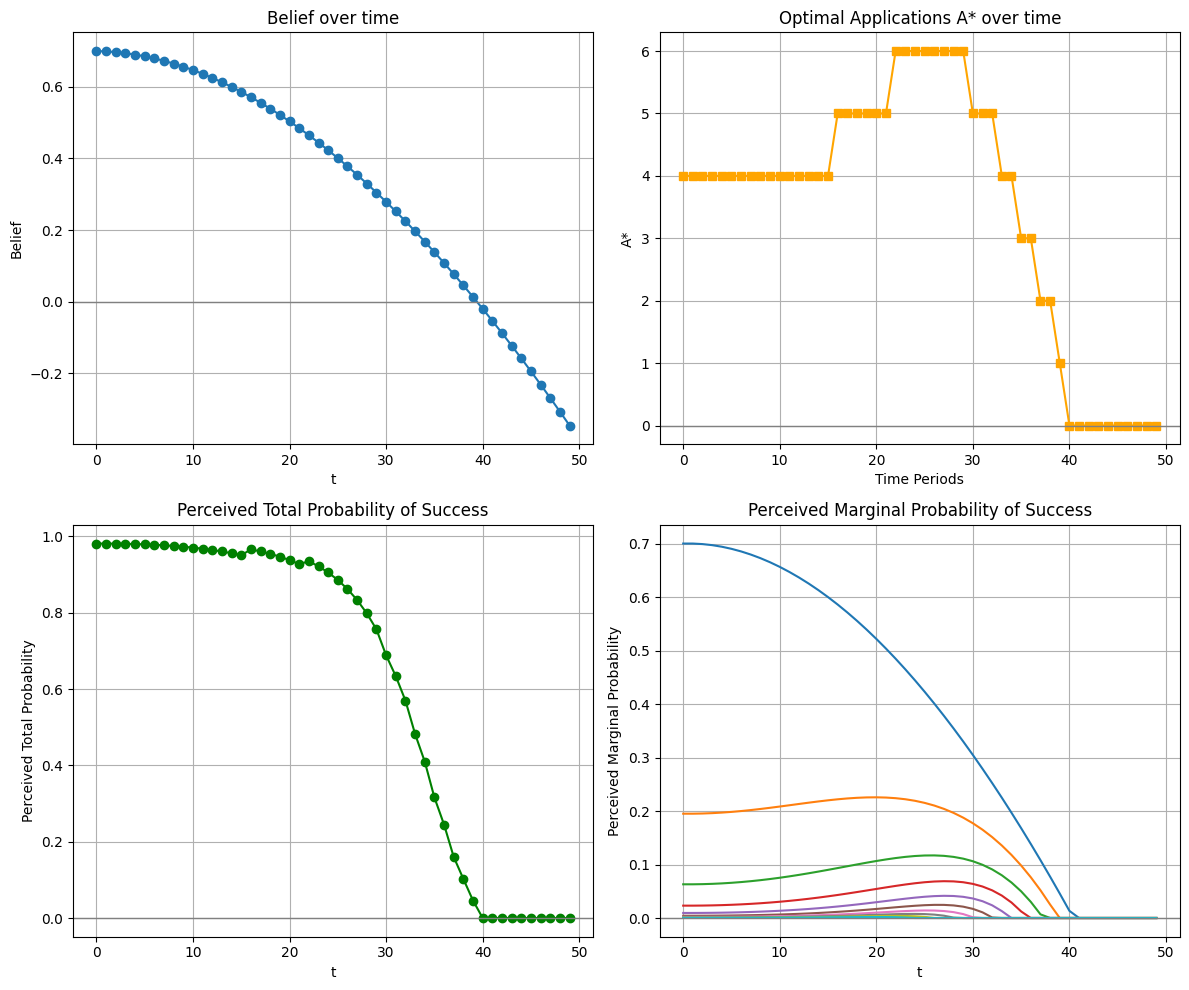

In [ ]:
# Belief updating

# Model helper functions
def make_p_vector_geom(p1, gamma, Amax):
    # p_k for k=1..Amax as a numpy array (0-indexed for k=1 at index 0)
    k = np.arange(Amax)
    return p1 * np.exp(-gamma * k)

def make_p_vector_linear(p1, gamma, Amax):
    """
    Linear decline across ranks:
      p_k = max(p1 - gamma*(k-1), 0)   for k=1..Amax
    Returned as a numpy array of length Amax (index 0 = k=1).
    """
    k = np.arange(Amax)            # 0..Amax-1 corresponds to k=1..Amax
    p = p1 - gamma * k
    # ensure valid probabilities
    p = np.clip(p, 0.0, 1.0)
    return p

def compute_MB_and_probs(p_vec, DeltaV):
    # p_vec is array p[0]=p1, p[1]=p2,...
    Amax = len(p_vec)
    MB = np.zeros(Amax)
    DeltaP = np.zeros(Amax)
    prod_term = 1.0
    for a in range(Amax):
        DeltaP[a] = prod_term * p_vec[a]
        MB[a] = DeltaP[a] * DeltaV
        prod_term *= (1 - p_vec[a])
    P_cum = 1 - np.cumprod(1 - p_vec)  # probability of ≥1 offer after A apps (elementwise)
    return MB, DeltaP, P_cum

def find_A_star(MB, c):
    # returns integer A* (0 means send zero applications)
    # MB is array for A=1..Amax stored at indices 0..Amax-1
    feasible = np.where(MB >= c)[0]
    if feasible.size == 0:
        return 0
    return int(feasible[-1] + 1)  # convert index to A (1-indexed)

def compute_P_of_A(p_vec, A):
    if A <= 0:
        return 0.0
    return 1 - np.prod(1 - p_vec[:A])

# --- Exponential-smoothing belief update (focused cell) ---
def update_beliefs(beta_old, outcome, omega, r, t):
    """Exponential smoothing update for belief beta in [0,1].
    outcome: 1 if success observed in the period, 0 otherwise.
    kappa: learning rate in (0,1).
    """
    return  beta_old + (1-np.exp(-omega*t)) * (outcome - r)

def simulate_agent_exp(T=50, beta0=0.5, omega=0.5, base_p1_factor=1.0,
                       gamma=0.05, DeltaV=50.0, c=1.0, Amax=10, Ve=100.0,
                       stop_on_employment=True, seed=None, r = 0.01):
    """Simulate a single agent using exponential smoothing for beliefs.
    Returns a list of dicts with period-by-period info."""
    import numpy as _np
    if seed is not None:
        _np.random.seed(seed)
    beta = beta0
    history = []
    for t in range(T):
        p1 = beta * base_p1_factor
        p_vec = make_p_vector_linear(p1, gamma, Amax)
        MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
        #print(p_vec == DeltaP)
        A_star = find_A_star(MB, c)
        P_of_A = compute_P_of_A(p_vec, A_star)
        offer = 0 #_np.random.rand() < P_of_A
        outcome = 1 if offer else 0
        beta = update_beliefs(beta, outcome, omega, r, t)
        history.append({'t': t, 'belief': beta, 'p1': p1, 'A_star': A_star,
                        'P_of_A': P_of_A, 'offer': offer, "DeltaP": DeltaP, "p_vec": p_vec})
        if offer == 1 and stop_on_employment:
            break
    return history




In [ ]:
demo = simulate_agent_exp(T=50, beta0=0.7, omega=0.01, seed=123, r = 0.1)

ts = [row['t'] for row in demo]
beliefs = [row['belief'] for row in demo]
A = [row['A_star'] for row in demo]

# Extract series
ts = [row['t'] for row in demo]
beliefs = [row['belief'] for row in demo]
A = [row['A_star'] for row in demo]
Ps_of_As = [row['P_of_A'] for row in demo]
p_vecs = [row['p_vec'] for row in demo]
DeltaPs = [row['DeltaP'] for row in demo]

# Create a 1x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(12,10))

# ---- Left plot: Belief over time ----
axes[0,0].plot(ts, beliefs, marker='o')
axes[0,0].axhline(0, color="grey", linewidth=1)
axes[0,0].set_title("Belief over time")
axes[0,0].set_xlabel("t")
axes[0,0].set_ylabel("Belief")
axes[0,0].grid(True)

# ---- Right plot: A* over time ----
axes[0,1].plot(ts, A, marker='s', color="orange")
axes[0,1].axhline(0, color="grey", linewidth=1)
axes[0,1].set_title("Optimal Applications A* over time")
axes[0,1].set_xlabel("Time Periods")
axes[0,1].set_ylabel("A*")
axes[0,1].grid(True)

# ---- Left plot: Belief over time ----
axes[1,0].plot(ts, Ps_of_As, marker='o', color = "green")
axes[1,0].axhline(0, color="grey", linewidth=1)
axes[1,0].set_title("Perceived Total Probability of Success")
axes[1,0].set_xlabel("t")
axes[1,0].set_ylabel("Perceived Total Probability")
axes[1,0].grid(True)

# ---- Left plot: Belief over time ----
axes[1,1].plot(ts, DeltaPs)
axes[1,1].axhline(0, color="grey", linewidth=1)
axes[1,1].set_title("Perceived Marginal Probability of Success")
axes[1,1].set_xlabel("t")
axes[1,1].set_ylabel("Perceived Marginal Probability")
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('output/theor_job_search_model/parameter_trajectories.png')
plt.show()


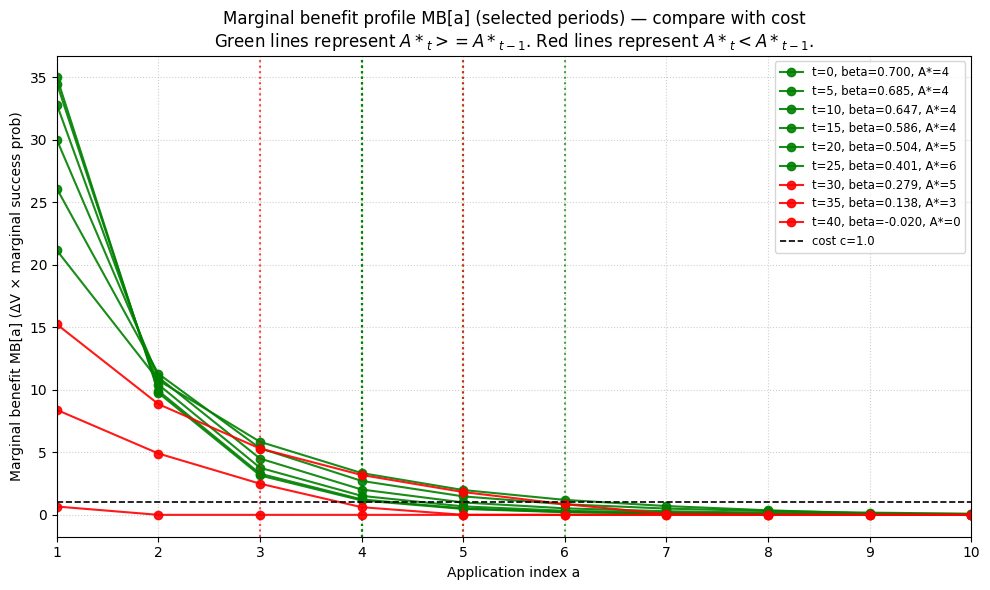

In [16]:
# -------------------------
# Additional minimal block: plot MB[a] vs a for selected times
# -------------------------
# Constants (match what you used in simulate_agent_exp)
DeltaV = 50.0   # must match the DeltaV used in simulate_agent_exp
c = 1.0         # must match the c used in simulate_agent_exp

# Choose which demo periods to plot (use actual t values present in demo)
# Here I pick a few early/mid/late periods; will automatically skip if not present.
selected_t = [0, 5, 10, 15, 20, 25, 30, 35, 40]

Amax = len(p_vecs[0])  # number of ranks (assumes no change in Amax across periods)
a_axis = np.arange(1, Amax+1)

plt.figure(figsize=(10,6))
A = 0
for i, t in enumerate(selected_t):
    # find the row index in demo with t (demo might have truncated early if employed)
    # demo is a list in time order so index = t if no break; we guard against out-of-range
    if t >= len(demo):
        continue
    p_vec = p_vecs[t]   # p_vec stored in history for that period
    MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
    Astar = find_A_star(MB, c)
    lbl = f"t={t}, beta={beliefs[t]:.3f}, A*={Astar}"
    if Astar >= A:
        color = "green"
        A = Astar
    else:
        color = "red"
        A = Astar
    plt.plot(a_axis, MB, marker='o', linestyle='-', label=lbl, color = color, alpha=0.9)
    if Astar > 0:
        plt.axvline(Astar, linestyle=':', alpha=0.7, color = color)


# plot cost line
plt.axhline(c, color='k', linestyle='--', linewidth=1.2, label=f"cost c={c}")

plt.xlabel("Application index a")
plt.ylabel("Marginal benefit MB[a] (ΔV × marginal success prob)")
plt.title("Marginal benefit profile MB[a] (selected periods) — compare with cost\nGreen lines represent $A*_t >= A*_{t-1}$. Red lines represent $A*_t < A*_{t-1}$.")
plt.legend(loc='upper right', fontsize='small', ncol=1)
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(1, Amax)
plt.tight_layout()
plt.savefig('output/theor_job_search_model/mb_vs_cost_curves.png')
plt.show()

50


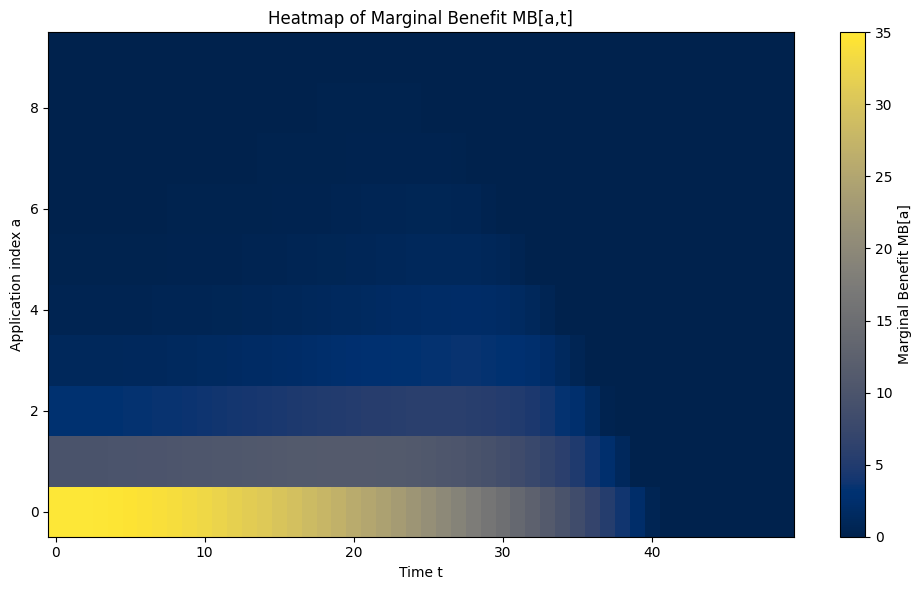

In [17]:
# Construct matrix M[t,a] = MB at time t for application a
T = len(p_vecs)          # total periods simulated
print(T)
Amax = len(p_vecs[0])
MB_matrix = np.zeros((T, Amax))

for t in range(T):
    MB, _, _ = compute_MB_and_probs(p_vecs[t], DeltaV)
    MB_matrix[t,:] = MB

plt.figure(figsize=(10,6))
plt.imshow(MB_matrix.T, aspect='auto', origin='lower', cmap='cividis')
plt.colorbar(label="Marginal Benefit MB[a]")
plt.ylabel("Application index a")
plt.xlabel("Time t")
plt.title("Heatmap of Marginal Benefit MB[a,t]")
plt.tight_layout()
plt.savefig('output/theor_job_search_model/mb_heatmap.png')
plt.show()

In [18]:

# Standard imports and helper functions
import numpy as np
import matplotlib.pyplot as plt

# Model helper functions
def make_p_vector(p1, gamma, Amax):
    # p_k for k=1..Amax as a numpy array (0-indexed for k=1 at index 0)
    k = np.arange(Amax)
    return p1 * np.exp(-gamma * k)

def compute_MB_and_probs(p_vec, DeltaV):
    # p_vec is array p[0]=p1, p[1]=p2,...
    Amax = len(p_vec)
    MB = np.zeros(Amax)
    DeltaP = np.zeros(Amax)
    prod_term = 1.0
    for a in range(Amax):
        DeltaP[a] = prod_term * p_vec[a]
        MB[a] = DeltaP[a] * DeltaV
        prod_term *= (1 - p_vec[a])
    P_cum = 1 - np.cumprod(1 - p_vec)  # probability of ≥1 offer after A apps (elementwise)
    return MB, DeltaP, P_cum

def find_A_star(MB, c):
    # returns integer A* (0 means send zero applications)
    # MB is array for A=1..Amax stored at indices 0..Amax-1
    feasible = np.where(MB >= c)[0]
    if feasible.size == 0:
        return 0
    return int(feasible[-1] + 1)  # convert index to A (1-indexed)

def compute_P_of_A(p_vec, A):
    if A <= 0:
        return 0.0
    return 1 - np.prod(1 - p_vec[:A])

def compute_Vu_given_Ve(c, A, P_of_A, Ve):
    # Solving V^u = -cA + P V^e + (1-P) V^u  =>  V^u = (-cA + P V^e) / P
    if P_of_A == 0:
        return np.nan  # no chance of employment; unemployed value undefined in this simple closure
    return (-c*A + P_of_A * Ve) / P_of_A


In [19]:

# === Belief-updating functions ===
# Exponential smoothing and Beta-Bernoulli conjugate update implementations

def update_belief_exp_smoothing(beta_old, outcome, kappa):
    """Exponential smoothing update for belief beta in [0,1].
    outcome: 1 if success observed in the period, 0 otherwise.
    kappa: learning rate in (0,1).
    """
    return (1 - kappa) * beta_old + kappa * outcome

def update_belief_beta(alpha_old, beta_old, outcome):
    """Beta(alpha,beta) prior; outcome in {0,1}.
    Returns updated (alpha_new, beta_new) and posterior mean.
    """
    alpha_new = alpha_old + outcome
    beta_new = beta_old + (1 - outcome)
    post_mean = alpha_new / (alpha_new + beta_new)
    return alpha_new, beta_new, post_mean

# Single-agent simulation (exponential smoothing)
def simulate_agent_exp(T=50, beta0=0.5, kappa=0.1, base_p1_factor=1.0,
                       gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, Ve=100.0,
                       stop_on_employment=True, seed=None):
    if seed is not None:
        np.random.seed(seed)
    beta = beta0
    history = []
    for t in range(T):
        p1 = beta * base_p1_factor
        p_vec = make_p_vector(p1, gamma, Amax)
        MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
        A_star = find_A_star(MB, c)
        P_of_A = compute_P_of_A(p_vec, A_star)
        offer = np.random.rand() < P_of_A
        outcome = 1 if offer else 0
        beta = update_belief_exp_smoothing(beta, outcome, kappa)
        history.append({'t': t, 'belief': beta, 'p1': p1, 'A_star': A_star,
                        'P_of_A': P_of_A, 'offer': offer})
        if offer and stop_on_employment:
            break
    return history

# Single-agent simulation (Bayesian Beta-Bernoulli)
def simulate_agent_bayes(T=50, alpha0=2.0, beta0_param=2.0, base_p1_factor=1.0,
                         gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, Ve=100.0,
                         stop_on_employment=True, seed=None):
    if seed is not None:
        np.random.seed(seed)
    a, b = alpha0, beta0_param
    history = []
    for t in range(T):
        belief = a / (a + b)
        p1 = belief * base_p1_factor
        p_vec = make_p_vector(p1, gamma, Amax)
        MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
        A_star = find_A_star(MB, c)
        P_of_A = compute_P_of_A(p_vec, A_star)
        offer = np.random.rand() < P_of_A
        outcome = 1 if offer else 0
        a, b, post_mean = update_belief_beta(a, b, outcome)
        history.append({'t': t, 'alpha': a, 'beta_param': b, 'belief': post_mean,
                        'p1': p1, 'A_star': A_star, 'offer': offer})
        if offer and stop_on_employment:
            break
    return history

# Population simulation (vectorized loop over agents)
def simulate_population_exp(N=500, T=40, kappa=0.08, beta0=0.5, base_p1_factor=1.0,
                            gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    betas = np.full(N, beta0, dtype=float)
    records = []
    for t in range(T):
        for i in range(N):
            p_vec = make_p_vector(betas[i] * base_p1_factor, gamma, Amax)
            MB, _, _ = compute_MB_and_probs(p_vec, DeltaV)
            A_star = find_A_star(MB, c)
            P_of_A = compute_P_of_A(p_vec, A_star)
            offer = np.random.rand() < P_of_A
            betas[i] = update_belief_exp_smoothing(betas[i], 1 if offer else 0, kappa)
            records.append({'t': t, 'agent': i, 'beta': betas[i],
                            'A_star': A_star, 'P_of_A': P_of_A, 'offer': offer})
    return records


Exponential smoothing single-agent sim (sample rows):
{'t': 0, 'belief': 0.384, 'p1': 0.3, 'A_star': 5, 'P_of_A': np.float64(0.5643376642927316), 'offer': np.True_}
[{'t': 0, 'belief': 0.384, 'p1': 0.3, 'A_star': 5, 'P_of_A': np.float64(0.5643376642927316), 'offer': np.True_}]

Bayesian single-agent sim (sample rows):
{'t': 0, 'alpha': 2.0, 'beta_param': 4.0, 'belief': 0.3333333333333333, 'p1': 0.4, 'A_star': 5, 'offer': np.False_}
{'t': 1, 'alpha': 2.0, 'beta_param': 5.0, 'belief': 0.2857142857142857, 'p1': 0.3333333333333333, 'A_star': 5, 'offer': np.False_}
{'t': 2, 'alpha': 2.0, 'beta_param': 6.0, 'belief': 0.25, 'p1': 0.2857142857142857, 'A_star': 5, 'offer': np.False_}
{'t': 3, 'alpha': 3.0, 'beta_param': 6.0, 'belief': 0.3333333333333333, 'p1': 0.25, 'A_star': 5, 'offer': np.True_}

Population aggregate (first 10 rows):
   t  mean_beta  mean_A  offer_rate
0  0   0.424800   5.000       0.710
1  1   0.448416   5.000       0.720
2  2   0.471743   4.475       0.740
3  3   0.489603  

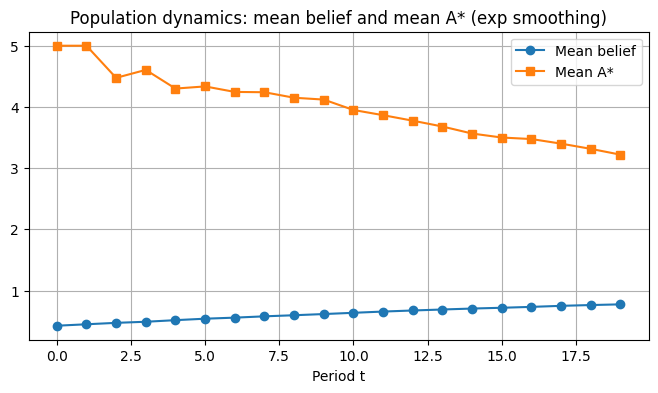

In [20]:

# === Demo: belief-updating simulations and plots ===
# Run a small demo for one exponential-smoothing agent and one Bayesian agent,
# plus a small population simulation to show aggregated belief dynamics.

# Single-agent exp smoothing demo
h_exp = simulate_agent_exp(T=30, beta0=0.3, kappa=0.12, base_p1_factor=1.0,
                           gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, Ve=100.0, seed=42)
print("Exponential smoothing single-agent sim (sample rows):")
for row in h_exp[:6]:
    print(row)

print(h_exp)

# Single-agent Bayesian demo
h_bayes = simulate_agent_bayes(T=30, alpha0=2.0, beta0_param=3.0, base_p1_factor=1.0,
                               gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, Ve=100.0, seed=24)
print("\nBayesian single-agent sim (sample rows):")
for row in h_bayes[:6]:
    print(row)

# Population demo (smaller N for speed)
pop_rec = simulate_population_exp(N=200, T=20, kappa=0.08, beta0=0.4,
                                  base_p1_factor=1.0, gamma=0.45, DeltaV=50.0,
                                  c=1.0, Amax=20, seed=123)

# Aggregate mean belief and application choice by period t
import pandas as pd
df = pd.DataFrame(pop_rec)
agg = df.groupby('t').agg(mean_beta=('beta', 'mean'), mean_A=('A_star', 'mean'),
                          offer_rate=('offer', 'mean')).reset_index()
print("\nPopulation aggregate (first 10 rows):")
print(agg.head(10))

# Plot mean belief over time and mean A*
plt.figure(figsize=(8,4))
plt.plot(agg['t'], agg['mean_beta'], marker='o', label='Mean belief')
plt.plot(agg['t'], agg['mean_A'], marker='s', label='Mean A*')
plt.xlabel('Period t')
plt.title('Population dynamics: mean belief and mean A* (exp smoothing)')
plt.legend()
plt.grid(True)
plt.show()

# # Save a small CSV of population records for inspection
# out_csv = '/mnt/data/population_sim_records.csv'
# df.to_csv(out_csv, index=False)
# print("\nSaved population simulation records to:", out_csv)


Baseline params: p1=0.12, gamma=0.45, DeltaV=50.0, c=1.0
A* = 4, P(>=1 offer | A*) = 0.2510, V^u (given V^e=100.0) = 84.066


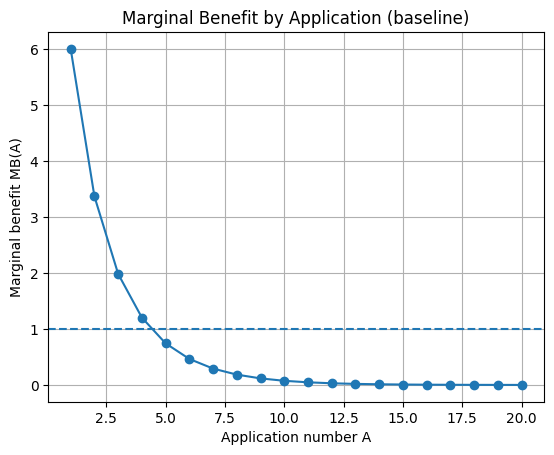

In [21]:

# Demo: baseline parameters and MB plot
p1 = 0.12
gamma = 0.45
DeltaV = 50.0
c = 1.0
Amax = 20

p_vec = make_p_vector(p1, gamma, Amax)
MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
A_star = find_A_star(MB, c)
P_of_A = compute_P_of_A(p_vec, A_star)
Ve = 100.0
Vu = compute_Vu_given_Ve(c, A_star, P_of_A, Ve)

print(f"Baseline params: p1={p1}, gamma={gamma}, DeltaV={DeltaV}, c={c}")
print(f"A* = {A_star}, P(>=1 offer | A*) = {P_of_A:.4f}, V^u (given V^e={Ve}) = {Vu:.3f}")

# Plot MB vs A
plt.figure()
A_vals = np.arange(1, Amax+1)
plt.plot(A_vals, MB, marker='o')
plt.axhline(c, linestyle='--')
plt.xlabel('Application number A')
plt.ylabel('Marginal benefit MB(A)')
plt.title('Marginal Benefit by Application (baseline)')
plt.grid(True)
plt.show()


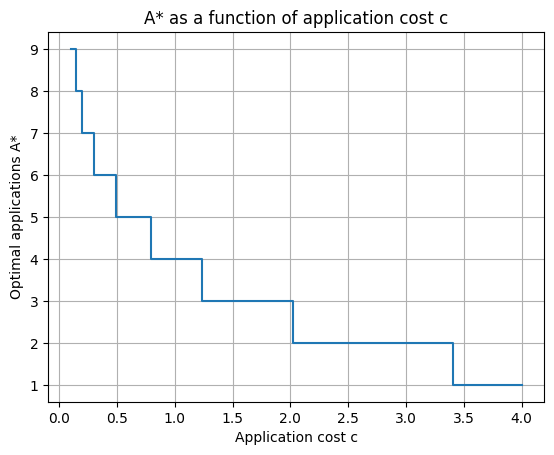

In [22]:

# Comparative statics: A* vs c
c_grid = np.linspace(0.1, 4.0, 80)
A_star_grid = []
for c_val in c_grid:
    MB, _, _ = compute_MB_and_probs(p_vec, DeltaV)
    A_star_grid.append(find_A_star(MB, c_val))

plt.figure()
plt.step(c_grid, A_star_grid, where='post')
plt.xlabel('Application cost c')
plt.ylabel('Optimal applications A*')
plt.title('A* as a function of application cost c')
plt.grid(True)
plt.show()


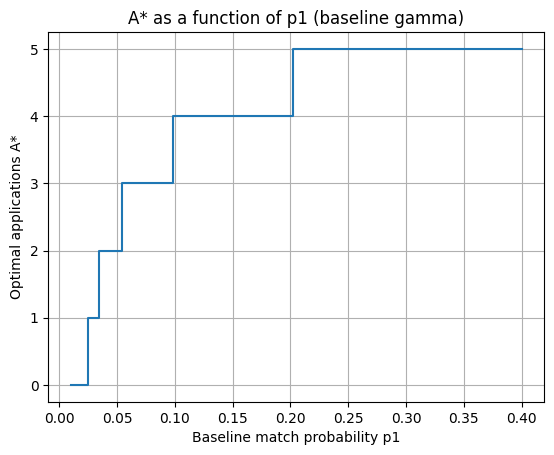

In [23]:

# Comparative statics: A* vs p1
p1_grid = np.linspace(0.01, 0.4, 80)
A_star_grid_p1 = []
for p1_val in p1_grid:
    ptmp = make_p_vector(p1_val, gamma, Amax)
    MBtmp, _, _ = compute_MB_and_probs(ptmp, DeltaV)
    A_star_grid_p1.append(find_A_star(MBtmp, c))

plt.figure()
plt.step(p1_grid, A_star_grid_p1, where='post')
plt.xlabel('Baseline match probability p1')
plt.ylabel('Optimal applications A*')
plt.title('A* as a function of p1 (baseline gamma)')
plt.grid(True)
plt.show()


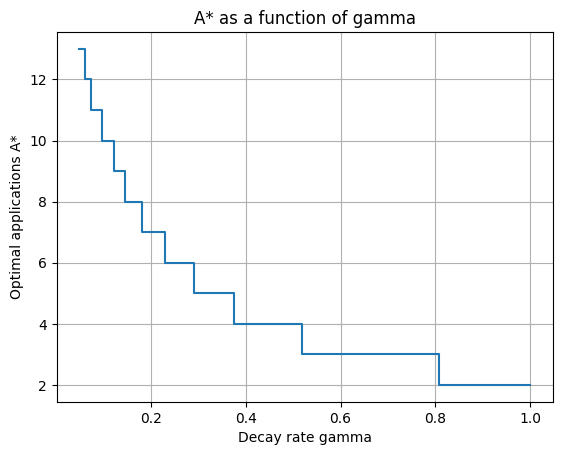

In [24]:

# Comparative statics: A* vs gamma
gamma_grid = np.linspace(0.05, 1.0, 80)
A_star_grid_gamma = []
for gamma_val in gamma_grid:
    ptmp = make_p_vector(p1, gamma_val, Amax)
    MBtmp, _, _ = compute_MB_and_probs(ptmp, DeltaV)
    A_star_grid_gamma.append(find_A_star(MBtmp, c))

plt.figure()
plt.step(gamma_grid, A_star_grid_gamma, where='post')
plt.xlabel('Decay rate gamma')
plt.ylabel('Optimal applications A*')
plt.title('A* as a function of gamma')
plt.grid(True)
plt.show()


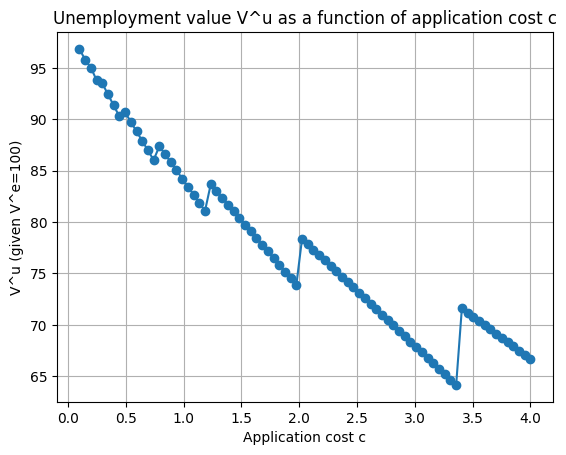

In [25]:

# V^u vs c (using Ve fixed)
c_grid = np.linspace(0.1, 4.0, 80)
Vu_grid = []
Agrid = []
for c_val in c_grid:
    MBtmp, _, _ = compute_MB_and_probs(p_vec, DeltaV)
    Aopt = find_A_star(MBtmp, c_val)
    Popt = compute_P_of_A(p_vec, Aopt)
    Vu_grid.append(np.nan if Popt==0 else compute_Vu_given_Ve(c_val, Aopt, Popt, Ve))
    Agrid.append(Aopt)

plt.figure()
plt.plot(c_grid, Vu_grid, marker='o')
plt.xlabel('Application cost c')
plt.ylabel('V^u (given V^e=%g)'%Ve)
plt.title('Unemployment value V^u as a function of application cost c')
plt.grid(True)
plt.show()


In [26]:

# --- Exponential-smoothing belief update (focused cell) ---
def update_belief_exp_smoothing(beta_old, outcome, kappa):
    """Exponential smoothing update for belief beta in [0,1].
    outcome: 1 if success observed in the period, 0 otherwise.
    kappa: learning rate in (0,1).
    """
    return (1 - kappa) * beta_old + kappa * outcome

def simulate_agent_exp(T=50, beta0=0.5, kappa=0.1, base_p1_factor=1.0,
                       gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, Ve=100.0,
                       stop_on_employment=True, seed=None):
    """Simulate a single agent using exponential smoothing for beliefs.
    Returns a list of dicts with period-by-period info."""
    import numpy as _np
    if seed is not None:
        _np.random.seed(seed)
    beta = beta0
    history = []
    for t in range(T):
        p1 = beta * base_p1_factor
        p_vec = make_p_vector(p1, gamma, Amax)
        MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
        A_star = find_A_star(MB, c)
        P_of_A = compute_P_of_A(p_vec, A_star)
        offer = _np.random.rand() < P_of_A
        outcome = 1 if offer else 0
        beta = update_belief_exp_smoothing(beta, outcome, kappa)
        history.append({'t': t, 'belief': beta, 'p1': p1, 'A_star': A_star,
                        'P_of_A': P_of_A, 'offer': offer})
        if offer and stop_on_employment:
            break
    return history

def simulate_population_exp(N=200, T=40, kappa=0.08, beta0=0.5, base_p1_factor=1.0,
                            gamma=0.45, DeltaV=50.0, c=1.0, Amax=20, seed=None):
    """Simulate a population of N agents with exponential smoothing updates.
    Returns a list of records (t, agent_id, belief, A_star, P_of_A, offer)."""
    import numpy as _np
    if seed is not None:
        _np.random.seed(seed)
    betas = _np.full(N, beta0, dtype=float)
    records = []
    for t in range(T):
        for i in range(N):
            p1 = betas[i] * base_p1_factor
            p_vec = make_p_vector(p1, gamma, Amax)
            MB, DeltaP, P_cum = compute_MB_and_probs(p_vec, DeltaV)
            A_star = find_A_star(MB, c)
            P_of_A = compute_P_of_A(p_vec, A_star)
            offer = _np.random.rand() < P_of_A
            # update belief using exponential smoothing
            betas[i] = update_belief_exp_smoothing(betas[i], 1 if offer else 0, kappa)
            records.append((t, i, float(betas[i]), int(A_star), float(P_of_A), bool(offer)))
    return records

# Quick demo run to show it works (prints first few periods)
try:
    import numpy as np
    _demo = simulate_agent_exp(T=20, beta0=0.4, kappa=0.12, seed=123)
    print('Demo (first 6 periods):')
    for r in _demo[:6]:
        print(r)
except Exception as _e:
    print('Note: run the notebook kernel first (this cell depends on the setup cell defining helper functions).', _e)


Demo (first 6 periods):
{'t': 0, 'belief': 0.35200000000000004, 'p1': 0.4, 'A_star': 5, 'P_of_A': np.float64(0.6867127569479624), 'offer': np.False_}
{'t': 1, 'belief': 0.42976000000000003, 'p1': 0.35200000000000004, 'A_star': 5, 'P_of_A': np.float64(0.6314299465401711), 'offer': np.True_}
